# 可视化类激活热力图的实践
# Project 2 
## 项目目标：用Grad-CAM技术以热力图形式将X.X节对于猫/狗输入图片的分类决策可视化
## 模型：5.2节自定义并训练好后保存的深度网络模型
## 输入图片：自己挑选一张猫/狗图片
## 输出图片：叠加在原始图片上的类激活热力图

## 1 加载自定义网络

In [99]:
from keras.models import load_model
#加载未使用数据增强的网络模型
#model_without_DR = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/cats_and_dogs_small_my_network_without_DR_0629.h5')
model_without_DR = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/cats_and_dogs_small_my_network_0625.h5')

In [100]:
#加载使用数据增强技术的网络模型
model_with_DR = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/cats_and_dogs_small_my_network_with_DR_0629.h5')

### 建议在这里先重温下保存模型的网络结构

In [101]:
model_without_DR.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [102]:
model_with_DR.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

## 2 加载输入图像

### 自己选定一张包含猫或狗的图片并加载

### 2.1 通过指定文件路径加载。因为该自定义模型默认输入图片的尺寸为150 x 150，因此加载图片是需指定尺寸。

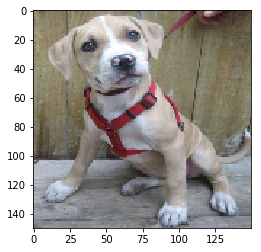

In [103]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline 

#指定非洲象图片存储路径
img_path = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/dogs/dog.1503.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
#https://keras.io/api/preprocessing/image/#load_img-function
#target = (height, weight)
img = image.load_img(img_path, target_size = (150, 150))
plt.imshow(img)

### 2.2 参照当时训练模型之前的预处理方法对原始图片进行处理
### 适配处理三部曲：“一转、二扩、三预”
### 一转：使用img_to_array，将数据从图片格式转换为数组格式
### 二扩：使用expand_dims，将输入图片张量数组扩大一个维度，新增加维度用于表示batch_size
### 三标：RGB值标准化

In [104]:
x1 = image.img_to_array(img)
import numpy as np
x2 = np.expand_dims(x1, axis = 0)
x3 = x2 * 1./255

### 可以对比下x2和x3区别

In [105]:
x2[0][0]

array([[134., 112.,  89.],
       [150., 134., 111.],
       [146., 131., 108.],
       [131., 116.,  95.],
       [122., 104.,  84.],
       [110.,  87.,  69.],
       [115.,  97.,  73.],
       [117., 107.,  80.],
       [132., 127.,  98.],
       [137., 132., 103.],
       [134., 124.,  97.],
       [130., 118.,  92.],
       [141., 129., 103.],
       [138., 126., 100.],
       [132., 120.,  94.],
       [127., 115.,  89.],
       [132., 120.,  94.],
       [140., 128., 104.],
       [131., 119.,  95.],
       [130., 118.,  94.],
       [123., 111.,  87.],
       [136., 124., 100.],
       [120., 108.,  84.],
       [ 96.,  94.,  95.],
       [154., 150., 141.],
       [125., 118., 100.],
       [139., 128., 108.],
       [146., 133., 114.],
       [133., 118.,  99.],
       [136., 125.,  97.],
       [136., 125.,  97.],
       [145., 134., 106.],
       [143., 132., 104.],
       [134., 123.,  95.],
       [133., 122.,  94.],
       [138., 127.,  99.],
       [144., 133., 105.],
 

In [106]:
x3[0][0]

array([[0.5254902 , 0.4392157 , 0.34901962],
       [0.5882353 , 0.5254902 , 0.43529412],
       [0.57254905, 0.5137255 , 0.42352942],
       [0.5137255 , 0.45490196, 0.37254903],
       [0.47843137, 0.40784314, 0.32941177],
       [0.43137255, 0.34117648, 0.27058825],
       [0.4509804 , 0.38039216, 0.28627452],
       [0.45882353, 0.41960785, 0.3137255 ],
       [0.5176471 , 0.49803922, 0.38431373],
       [0.5372549 , 0.5176471 , 0.40392157],
       [0.5254902 , 0.4862745 , 0.38039216],
       [0.50980395, 0.4627451 , 0.36078432],
       [0.5529412 , 0.5058824 , 0.40392157],
       [0.5411765 , 0.49411765, 0.39215687],
       [0.5176471 , 0.47058824, 0.36862746],
       [0.49803922, 0.4509804 , 0.34901962],
       [0.5176471 , 0.47058824, 0.36862746],
       [0.54901963, 0.5019608 , 0.40784314],
       [0.5137255 , 0.46666667, 0.37254903],
       [0.50980395, 0.4627451 , 0.36862746],
       [0.48235294, 0.43529412, 0.34117648],
       [0.53333336, 0.4862745 , 0.39215687],
       [0.

## 3 基于预训练的VGG16对输入图片进行分类预测

In [107]:
pred_without_DR = model_without_DR.predict(x3)
pred_without_DR

array([[0.6866994]], dtype=float32)

In [108]:
pred_with_DR = model_with_DR.predict(x3)
pred_with_DR

array([[0.8845002]], dtype=float32)

### (1)在无数据增强模型下，图片被划分为狗的概率为68.67%
### (2)在有数据增强模型下，图片被划分为狗的概率为88.45%

## 4 使用Grad-CAM算法计算出类激活热力图（本节最核心的部分）
### 给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权
### 使用底层张量库实现梯度、平均值等运算

### 4.1 用model.input表示输入图像数组

In [109]:
#VGG16的input层张量
#input层的API借口用法详见：https://keras.io/api/layers/core_layers/input/
model_without_DR.input

<tf.Tensor 'conv2d_1_input_6:0' shape=(None, 150, 150, 3) dtype=float32>

In [110]:
model_with_DR.input

<tf.Tensor 'conv2d_1_input_7:0' shape=(None, 150, 150, 3) dtype=float32>

### 4.2 用model.output表示分类预测结果 ，因为是二分类问题，输出结果为单值，可以直接表示

In [111]:
#class_output_without_DR = model_without_DR.output[:,0]
#class_output_with_DR = model_with_DR.output[:,0]
class_output_without_DR = model_without_DR.output
class_output_with_DR = model_with_DR.output

In [112]:
model_without_DR.output

<tf.Tensor 'dense_2_6/Sigmoid:0' shape=(None, 1) dtype=float32>

In [113]:
class_output_with_DR

<tf.Tensor 'dense_2_7/Sigmoid:0' shape=(None, 1) dtype=float32>

### 4.3 用last_conv_layer.output表示最后一个卷积层的输出特征张量

In [114]:
#get_layer https://keras.io/api/models/model/,返回的是该层实例对象，包含了很对属性,包括weights等
last_conv_layer_without_DR = model_without_DR.get_layer('conv2d_4')
last_conv_layer_with_DR = model_with_DR.get_layer('conv2d_4')

In [115]:
last_conv_layer_without_DR.output

<tf.Tensor 'conv2d_4_6/Relu:0' shape=(None, 15, 15, 128) dtype=float32>

### 4.4 求出类别求出相对于卷积层输出特征通道的梯度

In [116]:
#使用keras抽象的后端KPI
#https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
#可以看出K是作为抽象backend的一个类，可以用于tensorflow，也可以用于其他张量库——theano/cntk
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution() 

#调用后端的梯度计算张量库，对最后一个卷积层的输出求梯度，即对african_elephant_output求last_conv_layer.output的导数
#https://tensorflow.google.cn/api_docs/python/tf/keras/backend/gradients?hl=en
#y为african_elephant_output，表示第386号分类的预测输出结果,shape (batch_size,)
#x为last_conv_layer.output，表示最后一个卷积层的输出，shape (batch_size, 14, 14, 512)
grads_without_DR = K.gradients(class_output_without_DR, last_conv_layer_without_DR.output)[0]
grads_with_DR = K.gradients(class_output_with_DR, last_conv_layer_with_DR.output)[0]

In [117]:
grads_without_DR

<tf.Tensor 'gradients_6/max_pooling2d_4_6/MaxPool_grad/MaxPoolGrad:0' shape=(None, 15, 15, 128) dtype=float32>

In [118]:
grads_with_DR

<tf.Tensor 'gradients_7/max_pooling2d_4_7/MaxPool_grad/MaxPoolGrad:0' shape=(None, 15, 15, 128) dtype=float32>

### 4.4 使用K.mean() 对梯度进行标准化处理，即得到每个通道的平均梯度值

In [119]:
#梯度标准化，即求各通道平均值，平均数,即对每一层 15 x 15的矩阵求均值, (15,15,128) ----> (128,)
averaged_grads_without_DR = K.mean(grads_without_DR, axis =(0,1,2))
averaged_grads_with_DR = K.mean(grads_with_DR, axis =(0,1,2))

In [120]:
averaged_grads_without_DR

<tf.Tensor 'Mean_6:0' shape=(128,) dtype=float32>

### 4.5 使用K.function() 建立输入图片数组与最后一个卷积层输出特征张量、以及输出特征张量中每个通道平均梯度值之间的函数关系
### 1个输入、2个输出
### 输入：输入图片数组
### 输出：最后一个卷积层输出特征张量、输出特征张量中每个通道平均梯度值，即这个通道对最终预测类别的重要程度
### 参考地址：https://www.tensorflow.org/api_docs/python/tf/keras/backend/function

In [121]:
#调用后端function函数，初始化函数,指定输入和输出张量，实例化一个函数
#https://www.tensorflow.org/api_docs/python/tf/keras/backend/function
#因为只有批次里只有1个输入样本，因此last_conv_layer.output直接去第1个元素即可
#输入：图片数组
#输出1：输出类别对最后一个卷积层特征图中每个通道的平均梯度, (128,)
#输出2：最后一个卷积层的输出张量，(15,15,128)
iterate_without_DR = K.function([model_without_DR.input], [averaged_grads_without_DR, last_conv_layer_without_DR.output[0]])
iterate_with_DR = K.function([model_with_DR.input], [averaged_grads_with_DR, last_conv_layer_with_DR.output[0]])

### 4.6 使用自定义的函数iterate()，针对指定的猫或狗图片输入，输出为最后一个卷积层输出特征图 + 类别相对于输出特征图中各通道的平均梯度

In [122]:
#代入输入值
averaged_grads_without_DR_x, last_conv_layer_without_DR_x = iterate_without_DR([x3])
averaged_grads_with_DR_x, last_conv_layer_with_DR_x = iterate_with_DR([x3])

In [123]:
#最后一个卷积层128个通道的平均值
averaged_grads_without_DR_x.shape

(128,)

In [124]:
averaged_grads_without_DR_x

array([ 8.3530979e-04, -3.6563179e-03, -1.5183743e-05,  7.3210882e-05,
       -1.3034784e-03,  7.6170894e-04, -4.4426243e-03, -4.8567748e-04,
        4.5255949e-03, -1.4086011e-03,  3.8959424e-04, -1.3888722e-04,
        1.1056506e-05,  1.1413894e-03, -4.7774980e-04, -4.3651962e-04,
        1.4793150e-03,  1.0410252e-03, -1.4674002e-03, -5.6586851e-04,
        1.0836875e-03, -1.2066137e-04, -7.8740175e-04, -6.2901166e-04,
        3.1996844e-04, -9.3717122e-04,  6.7451358e-04,  5.3600437e-04,
        2.0150410e-03,  1.4650963e-03,  7.9711701e-04, -8.9663692e-04,
        1.3068041e-05, -3.6191013e-05, -1.0445644e-03,  5.6006823e-04,
        2.1025720e-03,  7.6462229e-04,  1.6611331e-04,  4.8388226e-04,
        9.9767116e-04,  1.8822843e-04, -8.2642003e-04, -8.7682100e-04,
       -1.1008408e-04,  7.3326111e-04, -5.1232544e-04, -1.9052046e-05,
        2.4334847e-03, -2.7036064e-04,  6.6566747e-05, -4.0451279e-03,
        2.6578674e-04, -5.3518624e-03, -4.8398066e-04, -2.1947308e-03,
      

In [125]:
last_conv_layer_without_DR_x

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.00428489, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.03316537, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.0746468 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [126]:
averaged_grads_with_DR_x

array([ 1.81627215e-03, -2.90088239e-03, -1.58417650e-04,  4.96727414e-04,
       -3.72674003e-06,  1.58668798e-03, -1.68091909e-03, -5.05492149e-04,
        3.16652516e-03,  1.38530356e-03, -3.95036535e-03,  7.27220380e-04,
       -3.34250461e-03,  1.53498759e-03,  2.34789462e-04, -5.24955336e-03,
       -5.22387680e-03,  8.25628988e-04, -7.27147143e-03, -2.72283796e-04,
       -9.08325252e-04, -7.64530338e-03,  2.17297510e-03,  7.72352680e-04,
        7.25125312e-04, -3.85588064e-05, -5.08571696e-03, -9.34956712e-04,
        1.75418623e-03, -4.61824797e-03, -5.96920075e-03,  6.59940823e-04,
        2.80499342e-03,  1.33817771e-03,  2.22185557e-03,  2.52050627e-03,
        1.68397697e-03,  2.18765787e-03,  3.51684727e-03,  2.05570552e-03,
       -6.50184508e-03,  4.47056693e-04,  5.01329824e-03,  3.69473174e-03,
       -1.04527443e-03,  6.82145415e-04, -2.22139037e-03, -7.20728142e-03,
        1.06364267e-03,  2.27991422e-03,  1.26796984e-03, -2.78838736e-04,
       -7.43485987e-03, -

### 4.7  将每个通道输出特征乘以这个通道对于'猫’类别的重要程度，并取各通道的平均值，即得到类激活的热力图数组

In [127]:
#last_conv_layer_x 形状为 (15,15,128)
for i in range(128):
    last_conv_layer_without_DR_x[:,:,i] *= averaged_grads_without_DR_x[i]
    last_conv_layer_with_DR_x[:,:,i] *= averaged_grads_with_DR_x[i]

In [128]:
#扁平化处理，即对最后一个轴方向求平均值,得到的形状为(15,15)；即对128个通道全部求平均值，记得到类激活的热力图
heatmap_without_DR = np.mean(last_conv_layer_without_DR_x, axis = -1)
heatmap_with_DR = np.mean(last_conv_layer_with_DR_x, axis = -1)

In [129]:
#最后一个卷积层的输出特征类激活图
heatmap_without_DR.shape

(15, 15)

In [130]:
heatmap_without_DR

array([[-1.0523539e-06,  3.2326793e-06,  6.2813169e-06, -2.7738827e-07,
        -5.6207853e-07, -6.1354910e-07, -4.5025718e-06, -3.7722641e-06,
        -2.1562849e-07,  1.3219855e-06,  2.6551177e-06, -8.5486948e-07,
        -6.0354853e-07, -6.1121142e-07, -1.3859081e-07],
       [-7.0820886e-07,  9.0099238e-06,  5.3480462e-06, -2.9717830e-06,
        -4.8577058e-06,  7.7226050e-06, -3.0749131e-06, -2.6394641e-06,
         2.2252591e-06,  3.4712757e-06,  6.0763296e-07, -1.3134722e-06,
        -4.1009816e-06, -7.1553245e-08, -1.0226128e-06],
       [-2.2503941e-06,  1.0121080e-06,  3.6523031e-06,  2.1231272e-06,
         2.2276222e-06,  8.0292057e-06, -3.0880444e-06, -1.2719321e-06,
         2.1846636e-06,  1.6551287e-06, -3.1570585e-07, -3.4899122e-06,
        -2.1330213e-06, -1.8535349e-07, -3.4037194e-07],
       [-4.5602146e-06, -5.3350368e-06, -6.6748407e-07, -1.1761585e-06,
         5.6057534e-06,  5.5105652e-06,  1.2700090e-07,  1.6486154e-06,
         3.0598926e-08,  1.5191027e-0

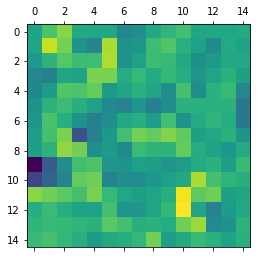

In [131]:
plt.matshow(heatmap_without_DR)

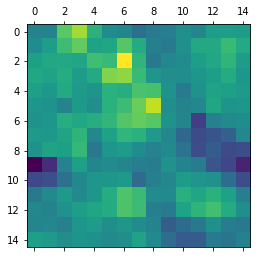

In [132]:
plt.matshow(heatmap_with_DR)

### 4.8 将类激活图的数组预处理后转换为图片

In [133]:
def heatmap_process(heatmap):  
    #为了将热力图可视化，去除所有负数
    heatmap_1 = np.maximum(heatmap, 0)
    #归一化处理
    heatmap_2 = heatmap_1 / np.max(heatmap_1)
    
    return heatmap_2

In [134]:
heatmap_pro_without_DR = heatmap_process(heatmap_without_DR)
heatmap_pro_with_DR = heatmap_process(heatmap_with_DR)

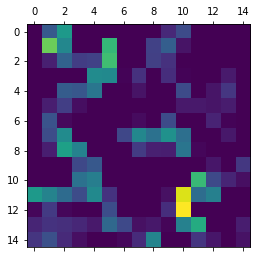

In [135]:
plt.matshow(heatmap_pro_without_DR)

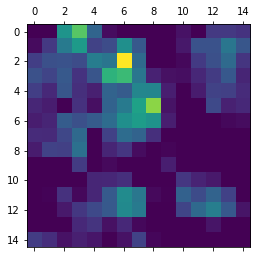

In [136]:
plt.matshow(heatmap_pro_with_DR)

### 5 将类激活热力图叠加在原始图像上

### 5.1 读取原始图像

In [137]:
#读取原始图像
import cv2
import cv2
#path_file = "E:/0-AI读书学习笔记/99-dataset-lib/test_kangbao.jpg"
path_file = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/dogs/dog.1503.jpg'
test = cv2.imdecode(np.fromfile(path_file, dtype = np.uint8), -1)
cv2.imshow('image',test)
cv2.waitKey(0)

-1

In [138]:
test.shape

(499, 420, 3)

### 5.2 调整类激活热力图的尺寸，与原始图像保持一致

In [139]:
#调整热图尺寸，与原图保持一致
#https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d
#shape:(x轴方向尺寸，y轴方向尺寸)

heatmap_resized_without_DR = cv2.resize(heatmap_pro_without_DR , (test.shape[1], test.shape[0]))
heatmap_resized_with_DR = cv2.resize(heatmap_pro_with_DR , (test.shape[1], test.shape[0]))

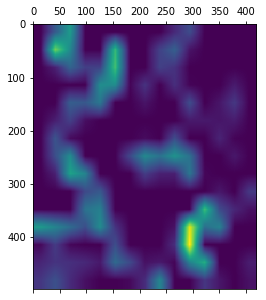

In [140]:
plt.matshow(heatmap_resized_without_DR)

In [141]:
heatmap_resized_without_DR

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.15475437, 0.15475437, 0.15475437, ..., 0.04742603, 0.04742603,
        0.04742603],
       [0.15475437, 0.15475437, 0.15475437, ..., 0.04742603, 0.04742603,
        0.04742603],
       [0.15475437, 0.15475437, 0.15475437, ..., 0.04742603, 0.04742603,
        0.04742603]], dtype=float32)

### 5.3 将类激活热力图转换为RGB格式

In [142]:
#将heatmap数组转换为（0,255）之间的无符号的unit8数值
heatmap_255_without_DR = np.uint8(255 * heatmap_resized_without_DR)
heatmap_255_with_DR = np.uint8(255 * heatmap_resized_with_DR)

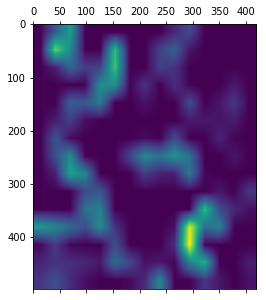

In [143]:
plt.matshow(heatmap_255_without_DR)

### 5.4 使用cv2.COLORMAP_JET选项进行渲染

In [144]:
#将热力图转换为喷射效果,applyColorMap？？？？
#cv2.applyColorMap选项可参考 https://docs.opencv.org/4.0.1/d3/d50/group__imgproc__colormap.html#gadf478a5e5ff49d8aa24e726ea6f65d15
#cv2.COLORMAP_JET https://docs.opencv.org/4.0.1/d3/d50/group__imgproc__colormap.html#ga9a805d8262bcbe273f16be9ea2055a65
heatmap_colormap_without_DR = cv2.applyColorMap(heatmap_255_without_DR, cv2.COLORMAP_JET)
heatmap_colormap_with_DR = cv2.applyColorMap(heatmap_255_with_DR , cv2.COLORMAP_JET)

### 5.5 以一定渲染强度将类激活热力图与原始图像叠加在一起

In [145]:
#将热力图与原始图像叠加， 0.5表示渲染强度, 有超出（0,255）范围的，如果需要可视化，则需要clip裁剪
superimposed_without_DR = heatmap_colormap_without_DR * 0.5 + test
superimposed_with_DR = heatmap_colormap_with_DR * 0.5 + test

### 5.6 将渲染后的图片存入指定路径

In [146]:
#解决cv2在写入路径中不识别中文路径问题
_path = "D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/grad_cam_dog_withoutDR.jpg"
cv2.imencode('.jpg',superimposed_without_DR)[1].tofile(_path)

In [147]:
#解决cv2在写入路径中不识别中文路径问题
_path = "D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/grad_cam_dog_withDR.jpg"
cv2.imencode('.jpg',superimposed_with_DR)[1].tofile(_path)

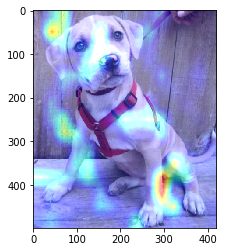

In [148]:
heatmap_img_without_DR = image.load_img('D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/grad_cam_dog_withoutDR.jpg')
plt.imshow(heatmap_img_without_DR)

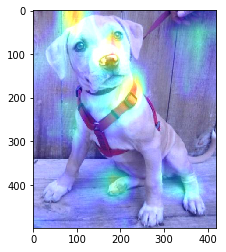

In [149]:
heatmap_img_with_DR = image.load_img('D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/grad_cam_dog_withDR.jpg')
plt.imshow(heatmap_img_with_DR)

### 通过对比上述两张图片，可以看到：
### （1）未使用数据增强技术的模型：影响分类决策的特征识别区域集中在肩膀、前足
### （2）使用数据增强技术的模型：影响分类决策的特征识别区域集中在头部（包括鼻子、嘴、额头）、后组

### 对于此测试图，虽然不使用数据增强技术的狗分类预测概率要大于使用数据增强技术模型的预测概率，但是通过热力图可以看到两个模型的分类决策过程差异较大，从可靠性上看，数据增强技术的模型要显著优于未使用数据增强的模型。